In [1]:
from typing import List
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import json
import os
import pandas as pd
from typing import NamedTuple


In [2]:
def calculate_mean_stddev(repositories, numerical_fields):
    num_files = len(repositories[0])
    mean_repo = []
    stddev_repo = []

    for file_index in range(num_files):
        all_files = [repo[file_index] for repo in repositories]

        data = {field: [] for field in numerical_fields}

        for file in all_files:
            for field in numerical_fields:
                data[field].append(file[field])

        mean_file = {
            field: np.mean(data[field], axis=0).tolist() for field in numerical_fields
        }
        stddev_file = {
            field: np.std(data[field], axis=0).tolist() for field in numerical_fields
        }

        mean_repo.append(mean_file)
        stddev_repo.append(stddev_file)

    return mean_repo, stddev_repo


def load_repository(directory):
    json_files = [f for f in sorted(os.listdir(directory)) if f.endswith(".json")]
    repository = []
    for json_file in json_files:
        with open(os.path.join(directory, json_file), "r") as f:
            repository.append(json.load(f))
    return repository


def process_repositories(parent_directory, numerical_fields):
    repo_dirs = [
        os.path.join(parent_directory, d)
        for d in os.listdir(parent_directory)
        if os.path.isdir(os.path.join(parent_directory, d)) and str(d).startswith("run")
    ]
    repositories = [load_repository(repo_dir) for repo_dir in repo_dirs]
    mean_repo, stddev_repo = calculate_mean_stddev(repositories, numerical_fields)

    return mean_repo, stddev_repo


def save_repository(repository, directory):
    os.makedirs(directory, exist_ok=True)
    for i, file in enumerate(repository):
        with open(os.path.join(directory, f"{i}.json"), "w") as f:
            json.dump(file, f, indent=2)


def main(algorithm: str):
    parent_dir = f"../logs/{algorithm}"
    numerical_fields = [
        "downloaded_bytes",
        "train_evals",
        "val_evals",
        "training_times",
        "agg_times",
    ]

    numerical_fields = [field.strip() for field in numerical_fields]

    mean_repo, stddev_repo = process_repositories(parent_dir, numerical_fields)

    # Save the results
    save_repository(mean_repo, f"{parent_dir}/mean_repo")
    save_repository(stddev_repo, f"{parent_dir}/stddev_repo")

    print("Mean and Standard Deviation repositories have been created.")


algorithms = ["local", "fedavg", "gossip", "dac", "dac2"]
for algorithm in algorithms:
    main(algorithm)


Mean and Standard Deviation repositories have been created.
Mean and Standard Deviation repositories have been created.
Mean and Standard Deviation repositories have been created.
Mean and Standard Deviation repositories have been created.
Mean and Standard Deviation repositories have been created.


In [3]:
def compute_evals(method: str) -> List[float]:
    dir_path = f"../logs/{method}/mean_repo"
    losses: List[float] = []
    for filename in sorted(os.listdir(dir_path)):
        with open(os.path.join(dir_path, filename)) as f:
            data = json.load(f)
        losses.append(data["val_evals"])

    return np.array(losses).mean(axis=0)


def compute_comm_megabytes(method: str) -> List[int]:
    dir_path = f"../logs/{method}/mean_repo"
    comm_bytes: List[int] = []
    for filename in sorted(os.listdir(dir_path)):
        with open(os.path.join(dir_path, filename)) as f:
            data = json.load(f)
        comm_bytes.append(data["downloaded_bytes"])

    return np.array(comm_bytes).sum(axis=0) / 1024**2


def find_milestone_round(losses: List[float], threshold: float) -> int:
    for i, value in enumerate(losses):
        if value < threshold:
            return i
    return -1


In [4]:
METHODS = ["local", "gossip", "dac", "dac2", "fedavg"]
MILESTONE_LOSS = 0.3
Method_Tuple = NamedTuple(
    "Method",
    method=str,
    milestone_round=int,
    total_comm_megabytes=int,
    final_eval=float,
)

method_tuples: List[Method_Tuple] = []
for method in METHODS:
    evals = compute_evals(method)
    milestone_round = find_milestone_round(evals, MILESTONE_LOSS)
    comm_megabytes = compute_comm_megabytes(method)
    total_comm_megabytes = sum(comm_megabytes[:milestone_round])

    if method != "fedavg":
        total_comm_megabytes = total_comm_megabytes / 76 # Server vs single client

    method_tuple = Method_Tuple(
        method=method,
        milestone_round=milestone_round,
        total_comm_megabytes=total_comm_megabytes,
        final_eval=evals[-1],
    )
    method_tuples.append(method_tuple)

df = pd.DataFrame(method_tuples)
df.to_csv("../assets/table.csv", index=False)
df


,method,milestone_round,total_comm_megabytes,final_eval
0,local,-1,0.000000,0.363257
1,gossip,78,2.857933,0.251630
2,dac,66,2.418251,0.236368
3,dac2,63,2.308331,0.235332
4,fedavg,63,35.086624,0.235674


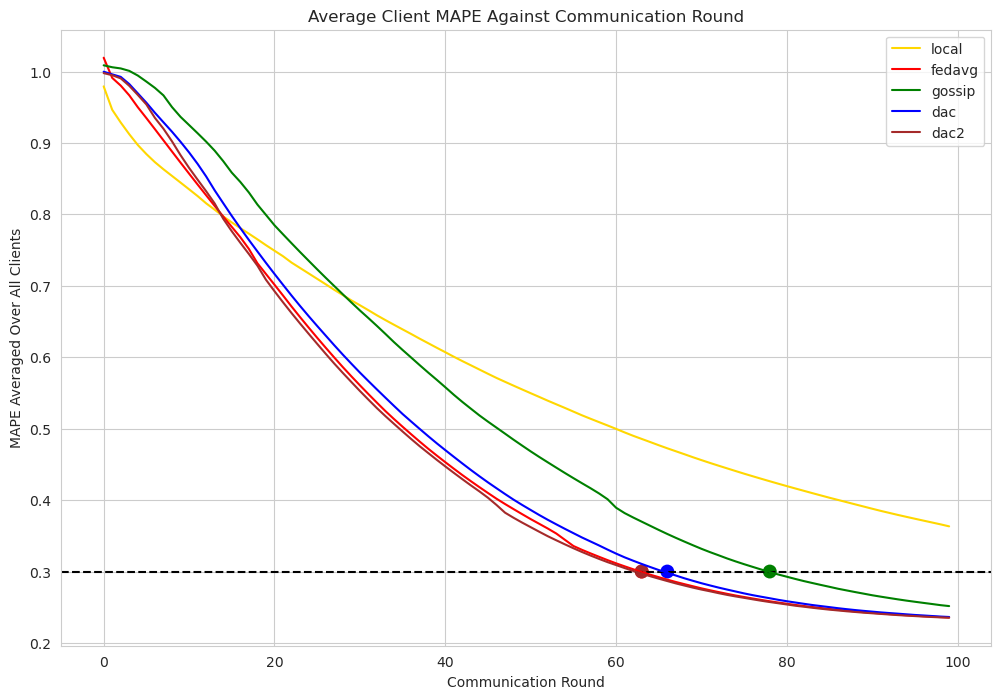

In [5]:
local_evals = compute_evals("local")
fedavg_evals = compute_evals("fedavg")
gossip_evals = compute_evals("gossip")
dac_evals = compute_evals("dac")
dac2_evals = compute_evals("dac2")
method2evals = {
    "local": local_evals,
    "fedavg": fedavg_evals,
    "gossip": gossip_evals,
    "dac": dac_evals,
    "dac2": dac2_evals,
}

MILESTONE_LOSS = 0.3
COLORS = ["gold", "red", "green", "blue", "brown"]

sns.set_style("whitegrid")
plt.figure(figsize=(12, 8))
plt.axhline(y=MILESTONE_LOSS, color="black", linestyle="--")

for (method, evals), color in zip(method2evals.items(), COLORS):
    plt.plot(evals, label=method, color=color)
    rounds = np.where(np.array(evals) <= MILESTONE_LOSS)[0]
    if rounds.size > 0:
        plt.scatter(
            rounds[0],
            MILESTONE_LOSS,
            s=100,
            color=color,
            marker="o",
            edgecolor="none",
        )

plt.legend()

plt.title("Average Client MAPE Against Communication Round")
plt.xlabel("Communication Round")
plt.ylabel("MAPE Averaged Over All Clients")

plt.savefig("../assets/plot1.png", bbox_inches="tight", facecolor="white")

plt.show()


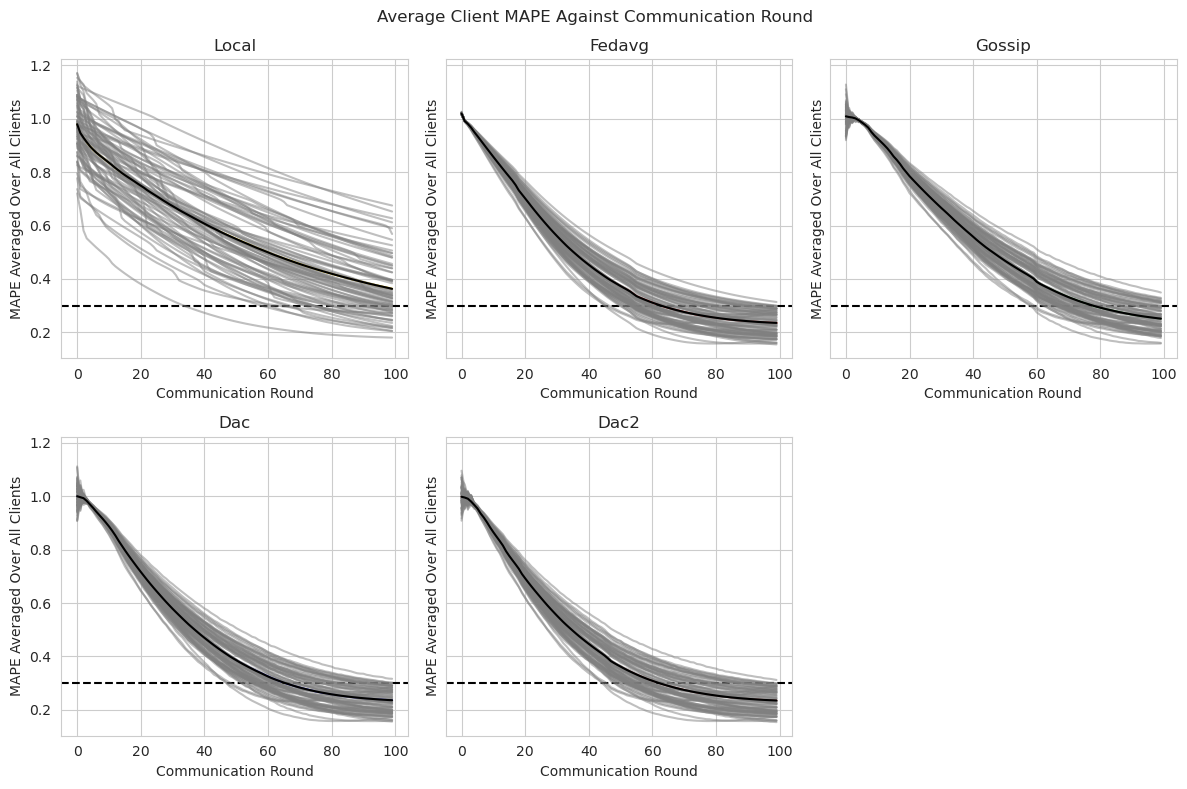

In [6]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8), sharey=True)

for (method, evals), ax, cidx in zip(
    method2evals.items(),
    axs.flat[: len(method2evals)],
    range(len(method2evals)),
):
    ax.plot(evals, label=method, color=COLORS[cidx])
    ax.axhline(y=MILESTONE_LOSS, color="black", linestyle="--")

    client_logs = []
    for filename in sorted(os.listdir(f"../logs/{method}/run_0")):
        with open(os.path.join(f"../logs/{method}/run_0", filename)) as f:
            client_log = json.load(f)["val_evals"]
        client_logs.append(client_log)

    for cidx, client_log in enumerate(client_logs):
        # Client 14 always diverges, just ignore it (sorry)
        if cidx == 14:
            continue
        ax.plot(client_log, label=f"Client {cidx}", color="gray", alpha=0.5)

    mean_losses = np.array(client_logs).mean(axis=0)
    ax.plot(mean_losses, label=f"Client {cidx}", color="black")

    ax.set_title(method.capitalize())
    ax.set_ylabel("MAPE Averaged Over All Clients")
    ax.set_xlabel("Communication Round")

# Turn off the sixth subplot
axs.flat[-1].axis("off")

fig.suptitle("Average Client MAPE Against Communication Round")
fig.tight_layout()

plt.savefig("../assets/plot2.png", bbox_inches="tight", facecolor="white")
plt.show()
